In [2]:
import numpy as np

embedding_matrix = np.load('embedding_matrix.npy', allow_pickle=True)
embedding_matrix.shape

(371815, 16)

In [3]:
import pickle

with open('ids.pkl', 'rb') as ids_bin:
    ids = pickle.loads(ids_bin.read())

In [7]:
import hdbscan

hbds_model = hdbscan.HDBSCAN(min_samples=1, cluster_selection_epsilon=0.01).fit(embedding_matrix)

In [ ]:
1+1

In [8]:
import pandas as pd

hbds_scan_labels = hbds_model.labels_
df = pd.DataFrame(zip(ids, hbds_scan_labels), columns = ['node_ids', 'hdbscan'])
df

,node_ids,hdbscan
0,0x213e4c9cbdc6112468aa6541674ac9b2d883d1ac,1
1,0x2c389165c3a0a61e259085c2d147a17bacfb55a2,1
2,0x875ebe92e4bcc8471db1707d749d06729aec12d4,1
3,0xca04ec8de1ebec40756fbd481b54aa5d773ff52b,1
4,0xe3fbf80f9a8f69f68f09a87a4f10f9a5f7ccc973,1
...,...,...
296246,0x1b412d11e1617d1babc0975cafa7133c1b61359f,1
296247,0xe4f9db5772388779e726c91e57a51281d54a538e,1
296248,0x0150a68730a70825180985c302c3b8296bccb1ea,1
296249,0x3e86f2826355e4b03eb80bb97ec3feebcfd2f6d4,1


In [37]:
import pandas as pd

df = pd.read_csv('hdbscan_custom.csv')
df

,node_ids,hdbscan
0,0x9483d055cc13f363f1799c69d9617cd624fc591a,4
1,0x9826a75c1c2c802def40cc3d239ebc17ceba4a75,4
2,0x7977b4d49f5782647bf7dfb963f86dc5bb0ab3f1,4
3,0xde2001423661953d2ad51e81507dcbaa0e826cb9,4
4,0xb76f6746b7e5c8376bb14d8536216448815b790d,4
...,...,...
371810,0xf3f4a129cf580b190498a98fdfcd7242bfd650bb,4
371811,0xc9658faf99631e05510730b4005b49962f8992b1,4
371812,0x43c20ac7afe3f2694889929d7c7f3794317cab17,4
371813,0xcf305b2bc598c3fc13ee4faafae144d93305cfe1,4


In [38]:
df.hdbscan.value_counts()

 4    366267
-1      5471
 1        52
 2        10
 3         8
 0         7
Name: hdbscan, dtype: int64

In [39]:
df = df.sample(frac=0.1)

In [40]:
labels = df.hdbscan.value_counts()
max_label = labels.index[0]
i = 2 # Para trazabilidad
df['hdbscan_merge_1'] = df['hdbscan']

while max_label != -1 and len(labels) > 2:
    print('Found {} clusters'.format(len(labels)))
    print(labels)
    print('Biggest cluster is {} with {} samples'.format(max_label, labels[max_label]))
    print('******************')
    print(f'HDBScanning for level {i}...')
    # HDBSCAN only using big cluster
    embeddings_next_level = embedding_matrix[df[previous_merge] == max_label]
    embeddings_next_level = hdbscan.HDBSCAN(min_samples=1, cluster_selection_epsilon=0.01).fit(embeddings_next_level)

    previous_merge = 'hdbscan_merge_{}'.format(i - 1)
    current_level = f'hdbscan_level_{i}'
    current_merge = f'hdbscan_merge_{i}'

    # Replace big cluster label with more segmented labels
    df.loc[df[previous_merge] == max_label, current_level] = embeddings_next_level.labels_

    # Extends
    df[current_merge] = df[previous_merge] + df[current_level]
    df.loc[df[current_level] == -1, current_merge] = -1

    # Keep the old labels for those who don't belong to big cluster
    df.loc[df[previous_merge] != max_label, current_merge] = df[df[previous_merge] != max_label][previous_merge]

    print('Saving DF...')
    df.to_csv('hdbscan_custom_recurrent.csv', index=False)
    labels = df[f'hdbscan_level_{i}'].value_counts()
    max_label = labels.index[0]
    i += 1
print('END')

Found 5 clusters
 4    36624
-1      549
 1        5
 3        3
 2        1
Name: hdbscan, dtype: int64
Biggest cluster is 4 with 36624 samples
******************
HDBScanning for level 2...


IndexError: boolean index did not match indexed array along dimension 0; dimension is 371815 but corresponding boolean dimension is 37182

In [14]:
labels = df.hdbscan.value_counts()
max_label = labels.index[0]

In [17]:
embedding_matrix[df.hdbscan == max_label]

(366267, 16)

In [22]:
import hdbscan

embeddings_level_2 = embedding_matrix[df.hdbscan == max_label]
hbds_model_level_2 = hdbscan.HDBSCAN(min_samples=1, cluster_selection_epsilon=0.01).fit(embeddings_level_2)

In [25]:
df.loc[df.hdbscan == max_label, 'hdbscan_level_2'] = hbds_model_level_2.labels_

In [28]:
df.hdbscan_level_2.value_counts()

 6.0    354373
-1.0     11853
 5.0        10
 0.0         9
 1.0         6
 4.0         6
 3.0         5
 2.0         5
Name: hdbscan_level_2, dtype: int64

In [31]:
df['hdbscan_merge'] = df['hdbscan'] + df['hdbscan_level_2']
df.loc[df.hdbscan_level_2 == -1, 'hdbscan_merge'] = -1
df.loc[df.hdbscan != max_label, 'hdbscan_merge'] = df[df.hdbscan != max_label]['hdbscan']
df

,node_ids,hdbscan,hdbscan_level_2,hdbscan_merge
0,0x9483d055cc13f363f1799c69d9617cd624fc591a,4,6.0,10.0
1,0x9826a75c1c2c802def40cc3d239ebc17ceba4a75,4,6.0,10.0
2,0x7977b4d49f5782647bf7dfb963f86dc5bb0ab3f1,4,6.0,10.0
3,0xde2001423661953d2ad51e81507dcbaa0e826cb9,4,6.0,10.0
4,0xb76f6746b7e5c8376bb14d8536216448815b790d,4,6.0,10.0
...,...,...,...,...
371810,0xf3f4a129cf580b190498a98fdfcd7242bfd650bb,4,6.0,10.0
371811,0xc9658faf99631e05510730b4005b49962f8992b1,4,6.0,10.0
371812,0x43c20ac7afe3f2694889929d7c7f3794317cab17,4,6.0,10.0
371813,0xcf305b2bc598c3fc13ee4faafae144d93305cfe1,4,6.0,10.0


In [34]:
df.hdbscan_level_2.value_counts()

 6.0    354373
-1.0     11853
 5.0        10
 0.0         9
 1.0         6
 4.0         6
 3.0         5
 2.0         5
Name: hdbscan_level_2, dtype: int64

In [32]:
df.hdbscan_merge.value_counts()

 10.0    354373
-1.0      17324
 1.0         52
 9.0         10
 2.0         10
 4.0          9
 3.0          8
 0.0          7
 5.0          6
 8.0          6
 7.0          5
 6.0          5
Name: hdbscan_merge, dtype: int64

In [6]:
import umap

embeddings_reduced = umap.UMAP(n_components=2, low_memory=True).fit(embedding_matrix)

/Users/mvbattan/Library/Caches/pypoetry/virtualenvs/pow_a_pos-zip6Mt8u-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-28 18:32:49.692910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
nodes_labels = df

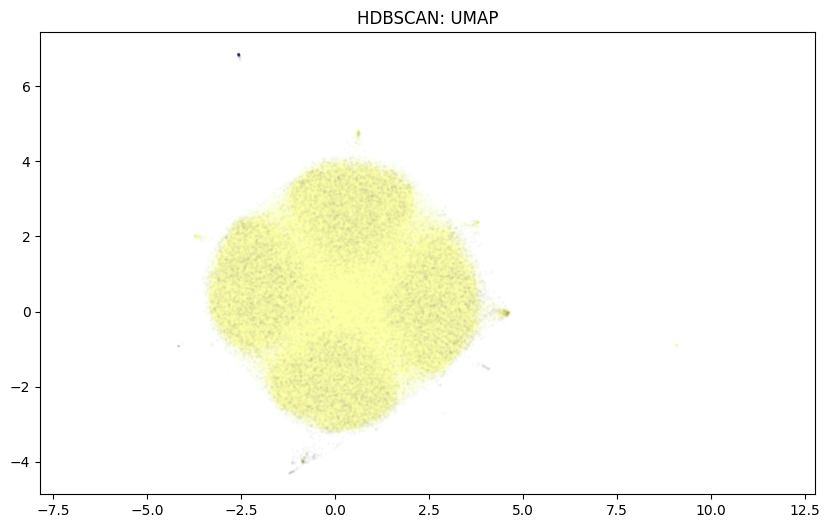

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(
    embeddings_reduced.embedding_[:, 0],
    embeddings_reduced.embedding_[:, 1],
    alpha=0.01,
    c=df.hdbscan_merge,
    cmap='inferno',
    s=2
)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'HDBSCAN: UMAP')
plt.savefig('hdbscan_umap.png')

In [30]:
embeddings_reduced.embedding_

array([[ 0.37105757,  4.9452868 ],
       [ 2.820072  ,  4.1930127 ],
       [ 0.4058273 ,  5.283232  ],
       ...,
       [-0.18396936,  4.3733397 ],
       [ 0.59680086,  2.876916  ],
       [ 0.4963619 ,  3.9946108 ]], dtype=float32)

In [43]:
hbds_model_reduced = hdbscan.HDBSCAN(min_samples=1, cluster_selection_epsilon=0.01).fit(embeddings_reduced.embedding_)

In [44]:
hbds_scan_labels = hbds_model_reduced.labels_
df_reduced = pd.DataFrame(zip(ids, hbds_scan_labels), columns = ['node_ids', 'hdbscan'])
df_reduced

,node_ids,hdbscan
0,0x213e4c9cbdc6112468aa6541674ac9b2d883d1ac,2535
1,0x2c389165c3a0a61e259085c2d147a17bacfb55a2,-1
2,0x875ebe92e4bcc8471db1707d749d06729aec12d4,4020
3,0xca04ec8de1ebec40756fbd481b54aa5d773ff52b,2126
4,0xe3fbf80f9a8f69f68f09a87a4f10f9a5f7ccc973,844
...,...,...
296246,0x1b412d11e1617d1babc0975cafa7133c1b61359f,5861
296247,0xe4f9db5772388779e726c91e57a51281d54a538e,6839
296248,0x0150a68730a70825180985c302c3b8296bccb1ea,2524
296249,0x3e86f2826355e4b03eb80bb97ec3feebcfd2f6d4,6989


In [45]:
df_reduced.hdbscan.value_counts()

 6989    109234
-1        15509
 5937      2204
 711       2029
 6244      1883
          ...  
 5088         5
 2076         5
 946          5
 148          5
 1515         5
Name: hdbscan, Length: 6991, dtype: int64

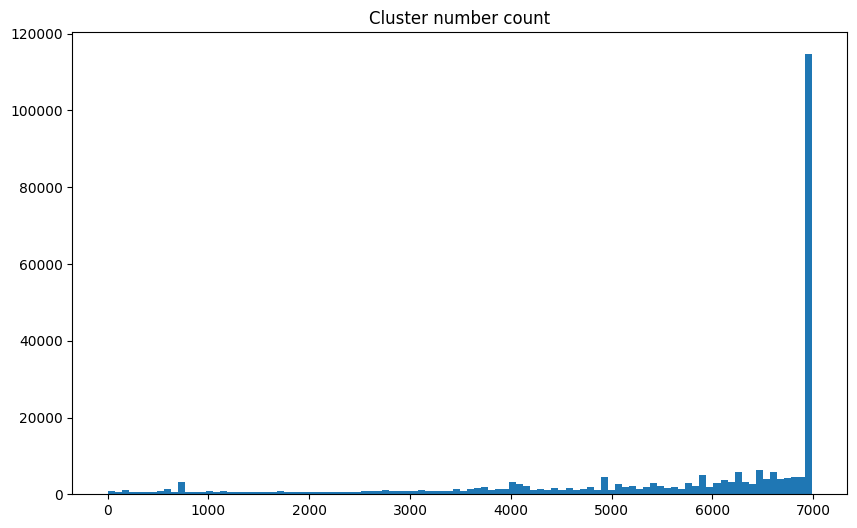

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(df_reduced[df_reduced.hdbscan != -1].hdbscan.values, bins=100)
plt.title('Cluster number count')
plt.show()

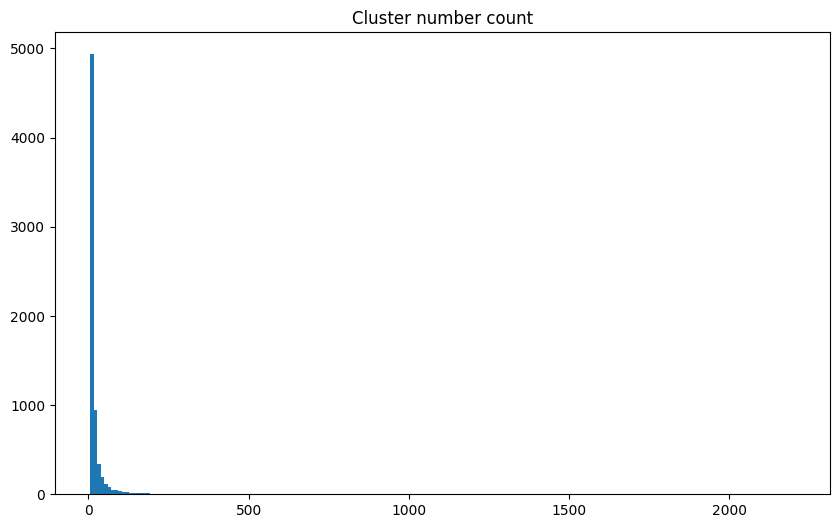

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(df_reduced[(df_reduced.hdbscan != -1) & (df_reduced.hdbscan != 6989)].hdbscan.value_counts().values, bins=200)
plt.title('Cluster number count')
plt.show()

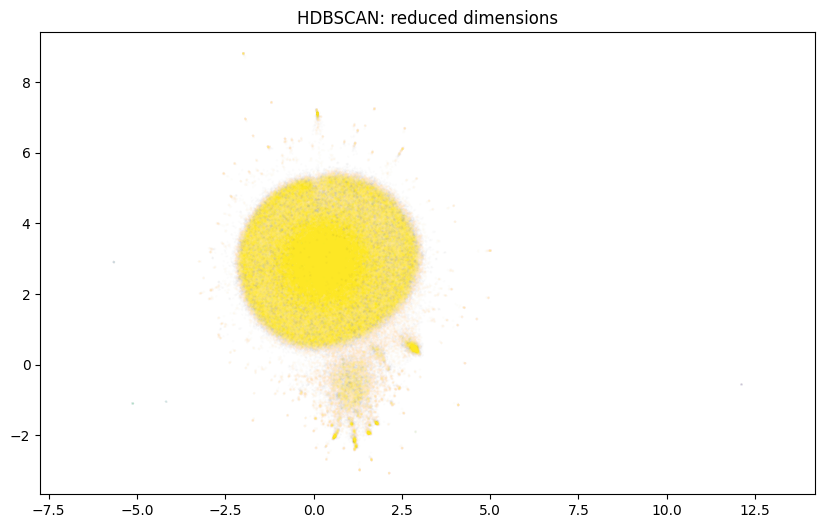

In [47]:
import matplotlib.colors as colors
plt.figure(figsize=(10, 6))

method = 'reduced dimensions'

cmap_colors = ['gray'] + [colors.to_hex(plt.cm.viridis(i)) for i in range(len(nodes_labels.hdbscan) - 1)]

cmap = colors.ListedColormap(cmap_colors)

plt.scatter(
    embeddings_reduced.embedding_[:, 0],
    embeddings_reduced.embedding_[:, 1],
    alpha=0.01,
    s=1,
    c=df_reduced.hdbscan,
    cmap=cmap
)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'HDBSCAN: {method}')
plt.savefig(f'hdbscan_{method}.png')

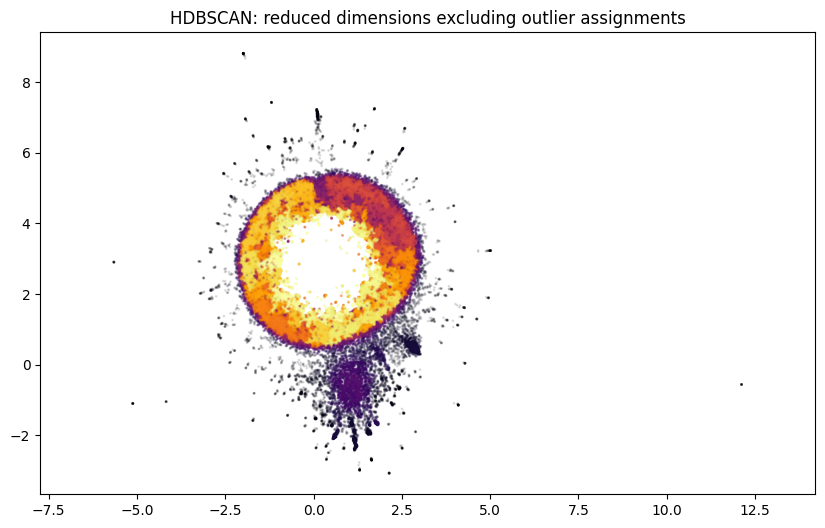

In [57]:
plt.figure(figsize=(10, 6))

method = 'reduced dimensions excluding outlier assignments'

cmap_colors = ['gray'] + [colors.to_hex(plt.cm.viridis(i)) for i in range(len(nodes_labels.hdbscan) - 1)]

cmap = colors.ListedColormap(cmap_colors)

plt.scatter(
    embeddings_reduced.embedding_[(df_reduced.hdbscan != -1) & (df_reduced.hdbscan != 6989)][:, 0],
    embeddings_reduced.embedding_[(df_reduced.hdbscan != -1) & (df_reduced.hdbscan != 6989)][:, 1],
    alpha=0.1,
    s=1,
    c=df_reduced[(df_reduced.hdbscan != -1) & (df_reduced.hdbscan != 6989)].hdbscan,
    cmap='inferno'
)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'HDBSCAN: {method}')
plt.savefig(f'hdbscan_{method}.png')

In [9]:
df.to_csv('pow_hdbscan.csv', index=False)

In [53]:
df_reduced.to_csv('pow_umap_hdbscan.csv', index=False)